<a href="https://www.kaggle.com/code/nabeelparuk/alzheimer-s-mri-classification-model?scriptVersionId=195811779" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

****

# **Alzheimer's MRI Image Classification Model**

*Created by Nabeel Paruk*

*Code available at: https://www.kaggle.com/datasets/borhanitrash/alzheimer-mri-disease-classification-dataset*

*RadImageNet pretrained models available at: https://github.com/BMEII-AI/RadImageNet*

*Last update: 20/08/2024*

*Accelerator used: GPU T4 x2*

****

# **Introduction**

Alzheimer's is a progressive disease that results in mild memory loss but can result in the inability to respond to an environment. According to the CDC, Alzheimer's is the most common form of dementia. This results in a huge problem for the aging population that needs to be addressed. Changes in the brain can appear years before symptoms present themselves. Thus, catching these changes and addressing the problem early would be incredibly useful. Artificial intelligence can be used in this way to predict whether a patient will experience Alzheimer's.

This project will use a custom convolutional net and InceptionV3 pretrained base from RadImageNet to predict level of dementia of a patient, classifying them into 'Non-demented', 'Very mild demented', 'Mild demented' and 'Moderate Demented'. The Alzheimer MRI Disease Classification Dataset from author Falah.G.Salieh will be used to train and validate the models.

****

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/radimagenet/RadImageNet-IRV2_notop.h5
/kaggle/input/radimagenet/RadImageNet-ResNet50_notop.h5
/kaggle/input/radimagenet/RadImageNet-DenseNet121_notop.h5
/kaggle/input/radimagenet/RadImageNet-InceptionV3_notop.h5
/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/README.md
/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet
/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet


## Import Data and Libraries

In [2]:
import math, re, os, warnings
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model


import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image_dataset_from_directory

import time

import warnings
warnings.filterwarnings('ignore')

2024-09-08 13:03:51.287239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 13:03:51.287392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 13:03:51.567701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


### Import data

**Set matplotlib defaults**

In [4]:
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [5]:
# Specify file paths

train_data_file_path = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet'
test_data_file_path = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet'

# Read data in

train_data = pd.read_parquet(train_data_file_path)
test_data = pd.read_parquet(test_data_file_path)

Turning byte format into img

In [6]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        return img

In [7]:
train_data['image'] = train_data['image'].apply(dict_to_image)
test_data['image'] = test_data['image'].apply(dict_to_image)

In [8]:
train_data.head()

,image,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2


**Split training data to get validation set**

In [9]:
X = train_data['image']
y = train_data['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.75, random_state=10)

In [10]:
X_test = test_data['image']
y_test = test_data['label']

Rejoin data into one dataframe

In [11]:
# Training data

X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
train_df = pd.concat([X_train_df, y_train_df], axis=1)

# Validation data

X_val_df = pd.DataFrame(X_val)
y_val_df = pd.DataFrame(y_val)
val_df = pd.concat([X_val_df, y_val_df], axis=1)

In [12]:
# Test data
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)
test_df = pd.concat([X_test_df, y_test_df], axis=1)

****

# **Exploratory Data Analysis**

In [13]:
train_df.head()

,image,label
4338,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
788,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
13,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
2143,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
2893,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0


**We can explore some images**

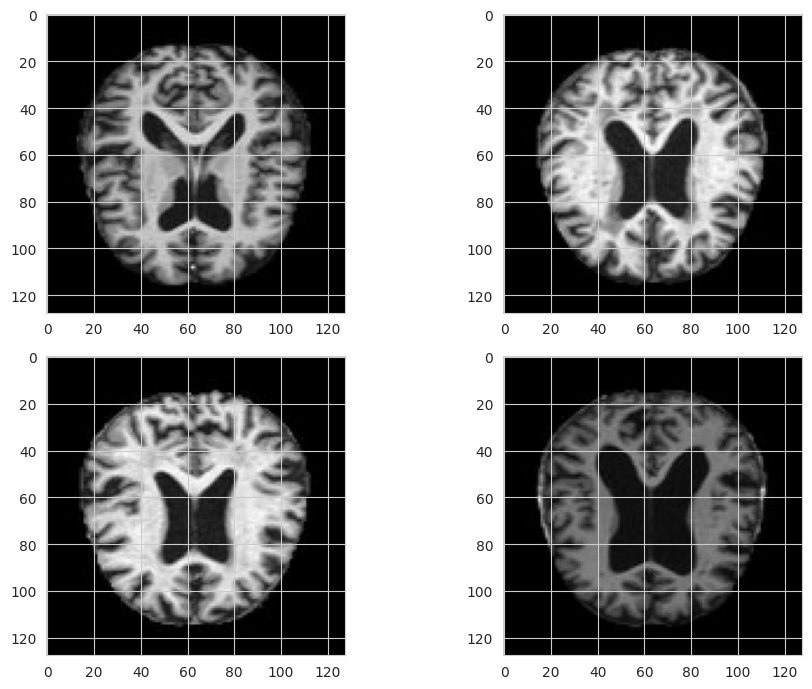

In [14]:
# Training images
mri_images = train_df['image']

fig = plt.figure(figsize=(10, 7)) 

for i in range(0, len(mri_images), 1000):
    n = int((i / 1000) + 1)
    
    fig.add_subplot(2,2,n)
    plt.imshow(mri_images.iloc[i])

plt.show()

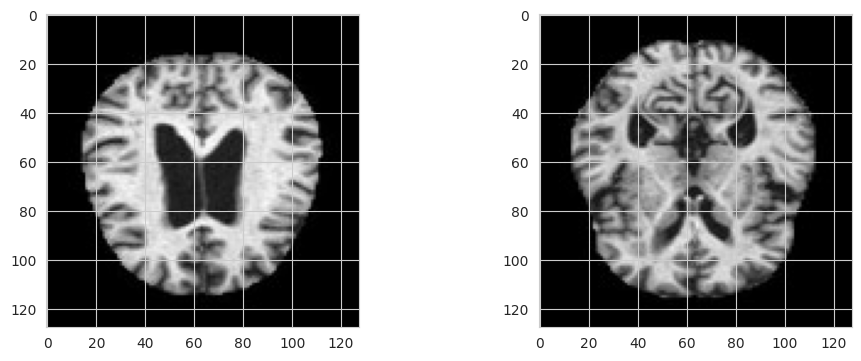

In [15]:
# Test images
mri_images_test = test_df['image']

fig = plt.figure(figsize=(10, 7)) 

for i in range(0, len(mri_images_test), 1000):
    n = int((i / 1000) + 1)
    
    fig.add_subplot(2,2,n)
    plt.imshow(mri_images_test.iloc[i])

plt.show()

Lets check the count of each label

In [16]:
labels = train_data['label']
label_counts = pd.DataFrame(labels.value_counts())
label_counts.index = ['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented']
label_counts

,count
Non Demented,2566
Very Mild Demented,1781
Mild Demented,724
Moderate Demented,49


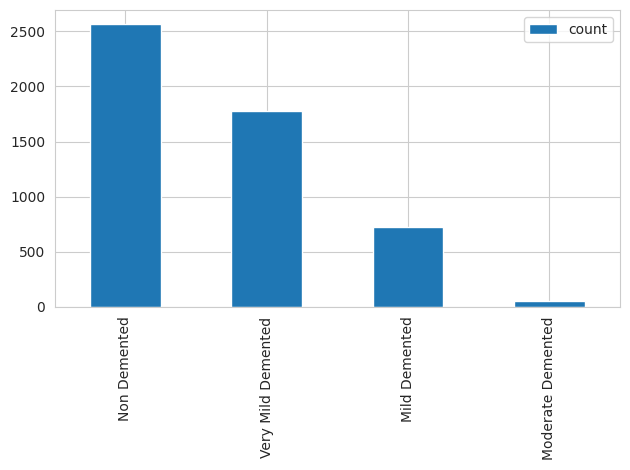

In [17]:
label_plot = label_counts.plot.bar()
plt.show()

There is a very clear class imbalance. With hardly any Moderate Demented and Mild Demented images, it will be well worth it to perform data augmentation to increase the class sizes.

Create scatterplot to view the classification plot

In [18]:
#plt.scatter(train_df.image[:, 0], train_ds.image[:, 1], c='label', cmap=plt.cm.RdYlBu);

****

# **Preprocessing**

### Reshape images

In [19]:
from tensorflow.keras.utils import to_categorical

# Define reshape function
def reshape_X_y(X, y):
    X_array = []
    for x in X:
        X_array.append(x)
    
    y = to_categorical(y)

    # Normalisation
    X_array = np.array(X_array)
    X_array = X_array / 255.0
    
    y = np.array(y)
    
    print(X_array.shape, y.shape)
    return X_array, y

# Training data
X_train_ds, y_train_ds = reshape_X_y(X_train, y_train)

# Validation data
X_val_ds, y_val_ds = reshape_X_y(X_val, y_val)

# Test data
X_test_ds, y_test_ds = reshape_X_y(X_test, y_test)

(3840, 128, 128, 3) (3840, 4)
(1280, 128, 128, 3) (1280, 4)
(1280, 128, 128, 3) (1280, 4)


### Define class names

In [20]:
class_names = np.array(['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented'])
print(class_names)

['Non Demented' 'Very Mild Demented' 'Mild Demented' 'Moderate Demented']


****

# **Model building**

## Defining Baseline Model Architectures

*We are going to create two models with differing bases: a custom convnet and an InceptionV3 pretrained base*

### Model 1: *Custom convolutional net*

In [21]:
model1 = keras.Sequential([
    
    # First Block
    layers.Conv2D(kernel_size=3, filters=32, input_shape=([128, 128, 3]), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Second Block
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

model1.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
start = time.time()

history1 = model1.fit(X_train_ds, y_train_ds,
                      steps_per_epoch=len(X_train_ds),
                      batch_size=32,
                      validation_data=(X_val_ds, y_val_ds),
                      validation_steps=len(X_val_ds),
                      epochs=40
)

print('It takes %s minutes' % ((time.time() - start)/60))

Epoch 1/40
  14/3840 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.4317 - loss: 1.2222

I0000 00:00:1725800700.524642      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1725800700.544048      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 10s 752us/step - accuracy: 0.5103 - loss: 1.0320 - val_accuracy: 0.5203 - val_loss: 0.9693
Epoch 2/40


W0000 00:00:1725800703.244047      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 435us/step - accuracy: 0.5470 - loss: 0.9582 - val_accuracy: 0.5883 - val_loss: 0.9316
Epoch 3/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step - accuracy: 0.5898 - loss: 0.8943 - val_accuracy: 0.5742 - val_loss: 0.9142
Epoch 4/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 437us/step - accuracy: 0.6217 - loss: 0.8349 - val_accuracy: 0.6555 - val_loss: 0.7719
Epoch 5/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 440us/step - accuracy: 0.7036 - loss: 0.7157 - val_accuracy: 0.7047 - val_loss: 0.6740
Epoch 6/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 440us/step - accuracy: 0.7684 - loss: 0.5866 - val_accuracy: 0.7586 - val_loss: 0.5837
Epoch 7/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 438us/step - accuracy: 0.8265 - loss: 0.4521 - val_accuracy: 0.7484 - val_loss: 0.6188
Epoch 8/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 453us/step - accuracy: 0.8776 - loss: 0.3315 - val_accuracy: 0.8508 - val_loss: 0.3799
Epoch 9/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 442us/step - accuracy: 0.9160 - loss: 0.24

In [23]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,642,062 (48.23 MB)

 Trainable params: 4,214,020 (16.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,428,042 (32.15 MB)

In [24]:
history1_plot = pd.DataFrame(history1.history)
history1_plot.head()

,accuracy,loss,val_accuracy,val_loss
0,0.510938,1.030764,0.520312,0.969270
1,0.547135,0.957776,0.588281,0.931577
2,0.590104,0.893702,0.574219,0.914216
3,0.622396,0.834159,0.655469,0.771909
4,0.703646,0.715173,0.704687,0.673999


### Model 2: *InceptionV3 Pretrained Base*

We need to resize our images

In [25]:
desired_size =(224, 224)

# Training data
X_train_resized_ds = tf.image.resize(X_train_ds, desired_size).numpy()

# Validation data
X_val_resized_ds = tf.image.resize(X_val_ds, desired_size).numpy()

# Test data
X_test_resized_ds = tf.image.resize(X_test_ds, desired_size).numpy()

In [26]:
inceptionv3_base_model = load_model('/kaggle/input/radimagenet/RadImageNet-InceptionV3_notop.h5')

for layer in inceptionv3_base_model.layers[:-3]:
    layer.trainable = False

In [27]:
model2 = keras.Sequential()

model2.add(inceptionv3_base_model)

# Add custom layers on top
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(4, activation='softmax'))

model2.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
start = time.time()

history2 = model2.fit(X_train_resized_ds, y_train_ds,
                      steps_per_epoch = len(X_train_resized_ds),
                      batch_size=32,
                      validation_data=(X_val_resized_ds, y_val_ds),
                      validation_steps=len(X_val_resized_ds),
                      epochs=40)

print('It takes %s minutes' % ((time.time() - start)/60))

Epoch 1/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.4760 - loss: 1.0980 - val_accuracy: 0.5102 - val_loss: 0.9815
Epoch 2/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5251 - loss: 1.0187 - val_accuracy: 0.5141 - val_loss: 0.9593
Epoch 3/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5291 - loss: 0.9914 - val_accuracy: 0.5219 - val_loss: 0.9444
Epoch 4/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5278 - loss: 0.9696 - val_accuracy: 0.5195 - val_loss: 0.9143
Epoch 5/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5234 - loss: 0.9656 - val_accuracy: 0.5258 - val_loss: 0.9126
Epoch 6/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5439 - loss: 0.9616 - val_accuracy: 0.5203 - val_loss: 0.9154
Epoch 7/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5356 - loss: 0.9503 - val_accuracy: 0.5242 - val_loss: 0.8965
Epoch 8/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5506 - loss: 0

In [29]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inceptionv3 (Functional)        │ (32, 5, 5, 2048)       │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 51200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 256)              │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 4)                │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,225,390 (233.56 MB)

 Trainable params: 13,140,868 (50.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 26,281,738 (100.26 MB)

In [30]:
history2_plot = pd.DataFrame(history2.history)
history2_plot.head()

,accuracy,loss,val_accuracy,val_loss
0,0.476562,1.096494,0.510156,0.981514
1,0.525260,1.018095,0.514063,0.959317
2,0.529167,0.991227,0.521875,0.944359
3,0.528125,0.969413,0.519531,0.914330
4,0.523698,0.965559,0.525781,0.912594


## **Evaluation of baseline models**

In [31]:
plt.rcParams['figure.figsize'] = [4, 4]

### Model 1: *Custom Convnet*

**Validation loss**

(0.0, 1.0)

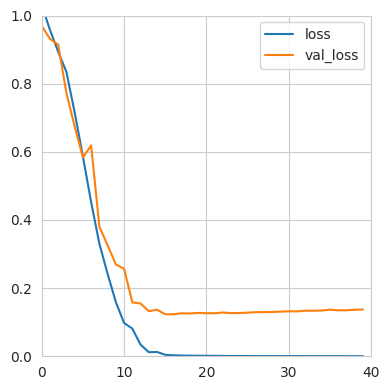

In [32]:
history1_plot.loc[:,['loss', 'val_loss']].plot()
plt.xlim(0, 40)
plt.ylim(0, 1)

**Validation Accuracy**

(0.0, 1.0)

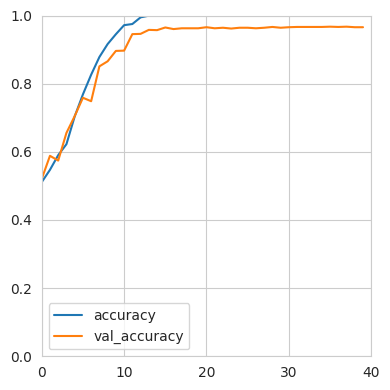

In [33]:
history1_plot.loc[:,['accuracy', 'val_accuracy']].plot()
plt.xlim(0, 40)
plt.ylim(0, 1)

### Model 2: *InceptionV3 Pretrained base*

**Validation Loss**

(0.0, 1.0)

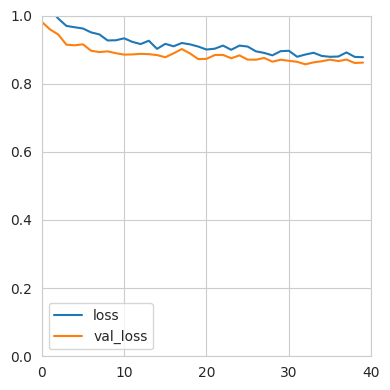

In [34]:
history2_plot.loc[:,['loss', 'val_loss']].plot()
plt.xlim(0, 40)
plt.ylim(0, 1)

**Validation Accuracy**

(0.0, 1.0)

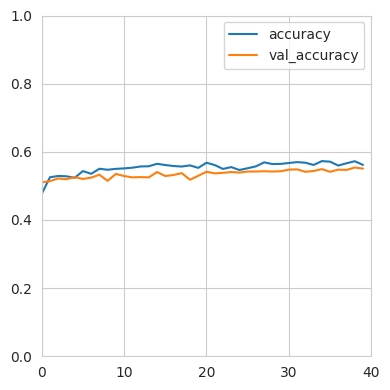

In [35]:
history2_plot.loc[:,['accuracy', 'val_accuracy']].plot()
plt.xlim(0, 40)
plt.ylim(0, 1)

****

# **Experiment with improving the models**

Both had very obvious flaws. The pretrained bases need to be finetuned to fit our specific data. There is an accuracy of around 0.5 for the InceptionV3 which is no better than guessing. The custom convnet is underfitting as shown by the large space between the training and validation curves.

## Model 1 Experimentation: *Custom convolutional net*

#### Experiment 1: EarlyStopping and Precision

We are going to experiment with using EarlyStopping. Due to the unbalanced classes, it is also a bad idea to use accuracy, thus we will use precision as our metric. As a general rule, changing more than one parameter at a time is not advised, but the use of accuracy as a metric is unlikely to continue, regardless.

In [36]:
# 1. Build experiment 1

model1_1 = keras.Sequential([
    
    # First Block
    layers.Conv2D(kernel_size=3, filters=32, input_shape=([128, 128, 3]), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    
    # Second Block
    layers.Conv2D(filters=64, activation='relu', padding='same', kernel_size=3),
    layers.MaxPool2D(),
    
    # Output Layers
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

# 2. Compile experiment 1

model1_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['precision'])

# - Define Early Stopping

earlystop1_1 = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=10)

# 3. Fit experiment 1

history1_1 = model1_1.fit(X_train_ds, y_train_ds,
                steps_per_epoch=len(X_train_ds),
                validation_data=(X_val_ds, y_val_ds),
                validation_steps=len(X_val_ds),
                batch_size=32,
                epochs=100,
                callbacks=[earlystop1_1])

Epoch 1/100
  10/3840 ━━━━━━━━━━━━━━━━━━━━ 1:10 18ms/step - loss: 1.3525 - precision: 0.4405

W0000 00:00:1725801316.744887      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 5s 779us/step - loss: 1.0202 - precision: 0.6103 - val_loss: 0.9109 - val_precision: 0.7376
Epoch 2/100


W0000 00:00:1725801319.555222      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 435us/step - loss: 0.8086 - precision: 0.7021 - val_loss: 0.7350 - val_precision: 0.7439
Epoch 3/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 442us/step - loss: 0.5304 - precision: 0.8252 - val_loss: 0.6062 - val_precision: 0.7707
Epoch 4/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 440us/step - loss: 0.2782 - precision: 0.9109 - val_loss: 0.3018 - val_precision: 0.8863
Epoch 5/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 440us/step - loss: 0.1305 - precision: 0.9585 - val_loss: 0.2374 - val_precision: 0.9125
Epoch 6/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 443us/step - loss: 0.0600 - precision: 0.9839 - val_loss: 0.1464 - val_precision: 0.9529
Epoch 7/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 441us/step - loss: 0.0250 - precision: 0.9937 - val_loss: 0.1059 - val_precision: 0.9679
Epoch 8/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 439us/step - loss: 0.0061 - precision: 0.9995 - val_loss: 0.1085 - val_precision: 0.9671
Epoch 9/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 442us/step - loss: 0.

<Axes: >

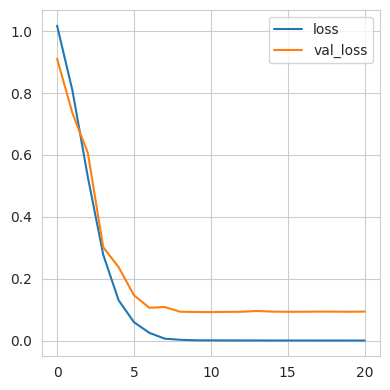

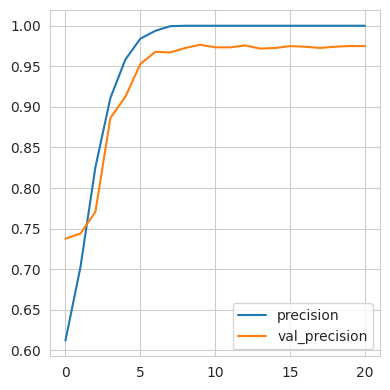

In [37]:
history1_1_plot = pd.DataFrame(history1_1.history)
history1_1_plot.loc[: , ['loss', 'val_loss']].plot()
history1_1_plot.loc[:, ['precision', 'val_precision']].plot()

#### Experiment 2: Finding the ideal learning rate

We can use the callback learning rate scheduler to visualise the most effective learning rate

In [38]:
# 1. Build experiment 2

model1_2 = keras.Sequential([
    
    # First Block
    layers.Conv2D(kernel_size=3, filters=32, input_shape=([128, 128, 3]), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    
    # Second Block
    layers.Conv2D(filters=64, activation='relu', padding='same', kernel_size=3),
    layers.MaxPool2D(),
    
    # Output Layers
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

# 2. Compile experiment 2

model1_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['precision'])

# - Define Early Stopping
earlystop1_2 = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=10)
# - Define Learnrate Scheduler
lrschedule1_2 = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))



# 3. Fit experiment 2

history1_2 = model1_2.fit(X_train_ds, y_train_ds,
                batch_size=32,
                steps_per_epoch=len(X_train_ds),
                validation_data=(X_val_ds, y_val_ds),
                validation_steps=len(X_val_ds),
                epochs=100,
                callbacks=[earlystop1_1, lrschedule1_2])

Epoch 1/100
  10/3840 ━━━━━━━━━━━━━━━━━━━━ 1:09 18ms/step - loss: 1.4945 - precision: 0.4391

W0000 00:00:1725801364.981776      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 5s 749us/step - loss: 1.0001 - precision: 0.6193 - val_loss: 0.8491 - val_precision: 0.6904 - learning_rate: 0.0010
Epoch 2/100


W0000 00:00:1725801367.678881      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 438us/step - loss: 0.7221 - precision: 0.7636 - val_loss: 0.6973 - val_precision: 0.6918 - learning_rate: 0.0011
Epoch 3/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 442us/step - loss: 0.3784 - precision: 0.8807 - val_loss: 0.3524 - val_precision: 0.8794 - learning_rate: 0.0013
Epoch 4/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 442us/step - loss: 0.2002 - precision: 0.9374 - val_loss: 0.2579 - val_precision: 0.9136 - learning_rate: 0.0014
Epoch 5/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 447us/step - loss: 0.0753 - precision: 0.9793 - val_loss: 0.1992 - val_precision: 0.9342 - learning_rate: 0.0016
Epoch 6/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step - loss: 0.0400 - precision: 0.9873 - val_loss: 0.1444 - val_precision: 0.9458 - learning_rate: 0.0018
Epoch 7/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 443us/step - loss: 0.0480 - precision: 0.9848 - val_loss: 0.2723 - val_precision: 0.9056 - learning_rate: 0.0020
Epoch 8/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 442us/step -

In [39]:
len(history1_2.history['loss'])

10

Text(0.5, 1.0, 'Finding ideal learning rate')

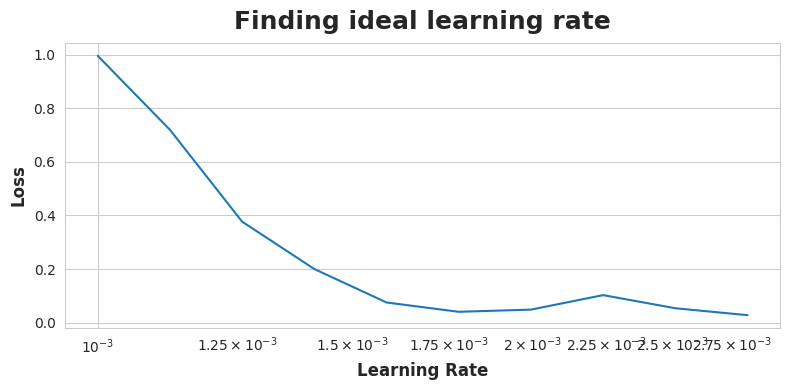

In [40]:
lrs = 1e-3 * (10**(tf.range(len(history1_2.history['loss']))/20))
plt.figure(figsize=(8,4))
plt.semilogx(lrs, history1_2.history['loss'])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Finding ideal learning rate")

It looks like 0.002 - 0.0025 is the ideal learning rate and the ideal number of epochs is 20

#### Experiment 3:

In [41]:
# 1. Build experiment 3

model1_3 = keras.Sequential([
    
    # First Block
    layers.Conv2D(kernel_size=3, filters=32, input_shape=([128, 128, 3]), activation='relu'),
    layers.MaxPool2D(),
    
    
    # Second Block
    layers.Conv2D(filters=64, activation='relu', kernel_size=3),
    layers.MaxPool2D(),
    
    # Output Layers
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

# 2. Compile experiment 1

lr1_3 = 0.002
epochs1_3 = 20
model1_3.compile(optimizer=tf.keras.optimizers.Adam(epsilon=lr1_3),
                loss='categorical_crossentropy',
                metrics=['precision'])

# - Define Early Stopping
earlystop1_3 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# 3. Fit experiment 1

history1_3 = model1_3.fit(X_train_ds, y_train_ds,
                steps_per_epoch=len(X_train_ds),
                batch_size=32,
                validation_data=(X_val_ds, y_val_ds),
                validation_steps=len(X_val_ds),
                epochs=epochs1_3,
                callbacks=[earlystop1_3])

Epoch 1/20
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 7s 742us/step - loss: 1.0307 - precision: 0.5803 - val_loss: 0.9696 - val_precision: 0.8279
Epoch 2/20
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 433us/step - loss: 0.9451 - precision: 0.6359 - val_loss: 0.8731 - val_precision: 0.7173
Epoch 3/20
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step - loss: 0.7898 - precision: 0.7274 - val_loss: 0.7086 - val_precision: 0.7596
Epoch 4/20
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 440us/step - loss: 0.5945 - precision: 0.7955 - val_loss: 0.5747 - val_precision: 0.7611
Epoch 5/20
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 435us/step - loss: 0.3699 - precision: 0.8837 - val_loss: 0.4244 - val_precision: 0.8312
Epoch 6/20
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step - loss: 0.2269 - precision: 0.9280 - val_loss: 0.2948 - val_precision: 0.8966
Epoch 7/20
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 435us/step - loss: 0.1330 - precision: 0.9580 - val_loss: 0.2108 - val_precision: 0.9246
Epoch 8/20
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 435us/step - loss

<Axes: >

<Figure size 800x1200 with 0 Axes>

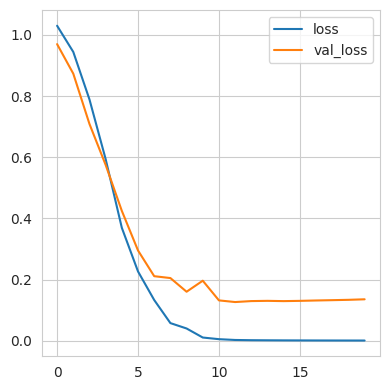

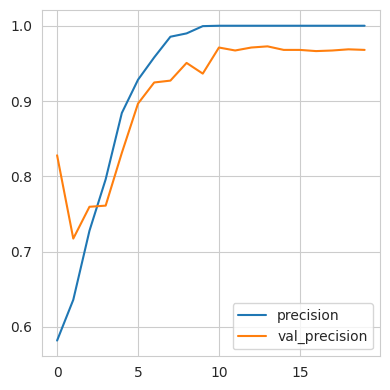

In [42]:
# Plot model
history1_3_plot = pd.DataFrame(history1_3.history)

plt.figure(figsize=(8,12))
history1_3_plot.loc[: , ['loss', 'val_loss']].plot()
history1_3_plot.loc[: , ['precision', 'val_precision']].plot()

#history1_plot.loc[: , ['loss', 'val_loss']].plot()

In [43]:
model1_3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,118,350 (42.41 MB)

 Trainable params: 3,706,116 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,412,234 (28.28 MB)

## Model 2 Experimentation: *InceptionV3 pretrained base*

#### Experiment 1: *Simplify the model by removing hidden layers*

In [44]:
# 1. Load a convolutional base with pre-trained weights
inceptionv3_base_model_test2 = load_model('/kaggle/input/radimagenet/RadImageNet-InceptionV3_notop.h5')

# - Freeze the base model
for layer in inceptionv3_base_model_test2.layers[:-4]:
    layer.trainable = False

# 2. Build model
model2_2 = keras.Sequential([
    inceptionv3_base_model_test2,
    layers.Flatten(),
    layers.Dense(1000),
    layers.Dense(4, activation='softmax')
])

# 3. Compile
model2_2.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['precision'])


start = time.time()
# 4. Fit model
history2_2 = model2_2.fit(X_train_resized_ds, y_train_ds,
                steps_per_epoch=len(X_train_resized_ds),
                batch_size=32,
                validation_data=(X_val_resized_ds, y_val_ds),
                validation_steps=len(X_val_resized_ds),
                epochs=40)

print('It takes %s minutes' % ((time.time() - start)/60))

Epoch 1/40
   2/3840 ━━━━━━━━━━━━━━━━━━━━ 6:40 104ms/step - loss: 1.3327 - precision: 0.0000e+00  

W0000 00:00:1725801462.638103      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 120/3840 ━━━━━━━━━━━━━━━━━━━━ 4:33 73ms/step - loss: 1.0632 - precision: 0.5291

W0000 00:00:1725801478.953990      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 1.0204 - precision: 0.5607 - val_loss: 1.2559 - val_precision: 0.4169
Epoch 2/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.9801 - precision: 0.5855 - val_loss: 0.9351 - val_precision: 0.5456
Epoch 3/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.9046 - precision: 0.6401 - val_loss: 0.9098 - val_precision: 0.5809
Epoch 4/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.9317 - precision: 0.6144 - val_loss: 0.8681 - val_precision: 0.6341
Epoch 5/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.8753 - precision: 0.6447 - val_loss: 0.8594 - val_precision: 0.6776
Epoch 6/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.8674 - precision: 0.6606 - val_loss: 0.8510 - val_precision: 0.6420
Epoch 7/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.8592 - precision: 0.6568 - val_loss: 0.8953 - val_precision: 0.6693
Epoch 8/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.8644 - precisio

(0.0, 1.0)

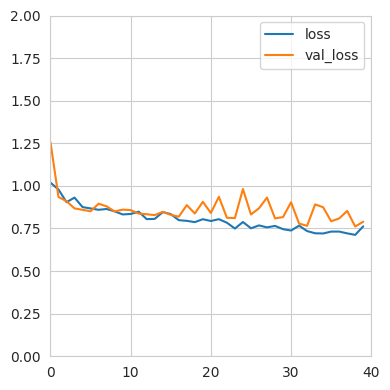

<Figure size 400x400 with 0 Axes>

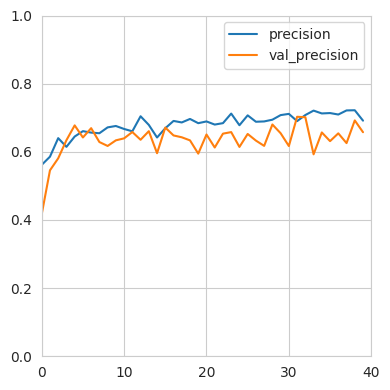

In [45]:
# 5. Plot model
history2_2_plot = pd.DataFrame(history2_2.history)
history2_2_plot.loc[: , ['loss', 'val_loss']].plot()
plt.xlim(0, 40)
plt.ylim(0,2)

plt.figure()
history2_2_plot.loc[: , ['precision', 'val_precision']].plot()
plt.xlim(0, 40)
plt.ylim(0, 1)

The loss seems like it is still decreasing. Let's run the model for a bit longer

#### Experiment 2: *Increase the number of epochs*

In [46]:
# 1. Load a convolutional base with pre-trained weights
inceptionv3_base_model_test3 = load_model('/kaggle/input/radimagenet/RadImageNet-InceptionV3_notop.h5')

# - Freeze the base model
for layer in inceptionv3_base_model_test3.layers[:-4]:
    layer.trainable = False
    
# 2. Build model
model2_3 = keras.Sequential([
    inceptionv3_base_model_test3,
    layers.Flatten(),
    layers.Dense(1000),
    layers.Dense(4, activation='softmax')
])

# 3. Compile
model2_3.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['precision'])


start = time.time()
# 4. Fit model
history2_3 = model2_3.fit(X_train_resized_ds, y_train_ds,
                    epochs=60,
                    batch_size=32,
                    steps_per_epoch=len(X_train_resized_ds),
                    validation_data=(X_val_resized_ds, y_val_ds),
                    validation_steps=len(X_val_resized_ds))

print('It takes %s minutes' % ((time.time() - start)/60))

Epoch 1/60
   2/3840 ━━━━━━━━━━━━━━━━━━━━ 7:09 112ms/step - loss: 1.3536 - precision: 0.0000e+00  

W0000 00:00:1725802020.506063      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 120/3840 ━━━━━━━━━━━━━━━━━━━━ 4:37 75ms/step - loss: 1.0521 - precision: 0.5372

W0000 00:00:1725802036.627145      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.0354 - precision: 0.5620 - val_loss: 0.9161 - val_precision: 0.5701
Epoch 2/60
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.9714 - precision: 0.6000 - val_loss: 0.9444 - val_precision: 0.5962
Epoch 3/60
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.9325 - precision: 0.6285 - val_loss: 0.9395 - val_precision: 0.5381
Epoch 4/60
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.8862 - precision: 0.6504 - val_loss: 0.8650 - val_precision: 0.6242
Epoch 5/60
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.8907 - precision: 0.6457 - val_loss: 0.8762 - val_precision: 0.6469
Epoch 6/60
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.8796 - precision: 0.6493 - val_loss: 0.8496 - val_precision: 0.6577
Epoch 7/60
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.8622 - precision: 0.6626 - val_loss: 0.8649 - val_precision: 0.6149
Epoch 8/60
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.8660 - precisio

(0.0, 1.0)

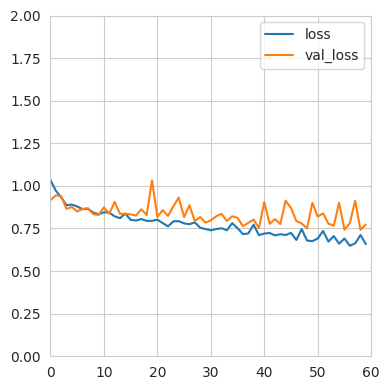

<Figure size 400x400 with 0 Axes>

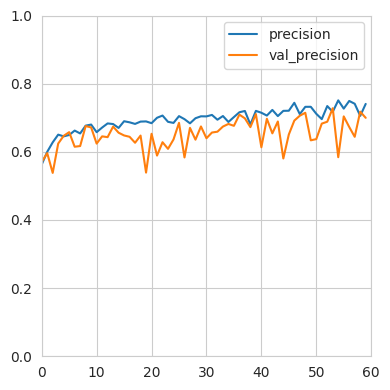

In [47]:
# 5. Plot model
history2_3_plot = pd.DataFrame(history2_3.history)
history2_3_plot.loc[: , ['loss', 'val_loss']].plot()
plt.xlim(0, 60)
plt.ylim(0, 2)

plt.figure()
history2_3_plot.loc[: , ['precision', 'val_precision']].plot()
plt.xlim(0, 60)
plt.ylim(0, 1)

The model is getting high spikes in the loss. Lets attempt to remedy this by changing the learning rate

#### Experiment 3: *Reduce the learning rate to reduce the spikes*

In [48]:
# 1. Load a convolutional base with pre-trained weights
inceptionv3_base_model_test4 = load_model('/kaggle/input/radimagenet/RadImageNet-InceptionV3_notop.h5')

# - Freeze the base model
for layer in inceptionv3_base_model_test4.layers[:-4]:
    layer.trainable = False
    
# 2. Build model
model2_4 = keras.Sequential([
    inceptionv3_base_model_test4,
    
    layers.Flatten(),
    layers.Dense(1000),
    layers.Dense(4, activation='softmax')
])

# 3. Compile model
model2_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(epsilon=0.01, learning_rate=0.01),
                metrics=['precision'])


start = time.time()
# 4. Fit model
history2_4 = model2_4.fit(X_train_resized_ds, y_train_ds,
    steps_per_epoch=len(X_train_resized_ds),
    epochs=60,
    batch_size=32,
    validation_data=[X_val_resized_ds, y_val_ds],
    validation_steps=len(X_val_resized_ds))

print('It takes %s minutes' % ((time.time() - start)/60))

Epoch 1/60
   2/3840 ━━━━━━━━━━━━━━━━━━━━ 6:14 97ms/step - loss: 1.7951 - precision: 0.2344       

W0000 00:00:1725802758.865737      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 120/3840 ━━━━━━━━━━━━━━━━━━━━ 4:34 74ms/step - loss: 1.7227 - precision: 0.4869

W0000 00:00:1725802774.803685      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.2635 - precision: 0.5544 - val_loss: 1.0257 - val_precision: 0.5491
Epoch 2/60
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.9405 - precision: 0.6250 - val_loss: 0.9410 - val_precision: 0.5873
Epoch 3/60
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.9694 - precision: 0.6113 - val_loss: 0.8967 - val_precision: 0.6056
Epoch 4/60
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.9416 - precision: 0.6010 - val_loss: 0.8876 - val_precision: 0.6625
Epoch 5/60
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.9298 - precision: 0.6154 - val_loss: 0.9110 - val_precision: 0.5994
Epoch 6/60
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.9349 - precision: 0.6140 - val_loss: 0.9197 - val_precision: 0.5882
Epoch 7/60
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.9217 - precision: 0.6212 - val_loss: 0.8640 - val_precision: 0.6513
Epoch 8/60
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.9041 - precisio

In [49]:
model2_4.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inceptionv3 (Functional)        │ (32, 5, 5, 2048)       │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (32, 51200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (32, 1000)             │    51,201,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (32, 4)                │         4,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,417,798 (669.17 MB)

 Trainable params: 51,205,004 (195.33 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 102,410,010 (390.66 MB)

(0.0, 1.0)

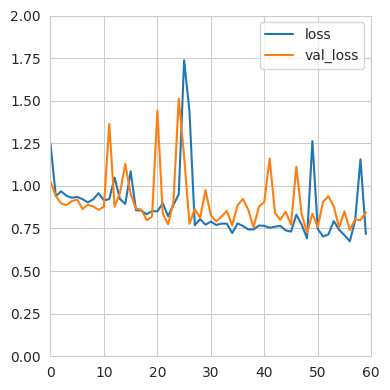

<Figure size 400x400 with 0 Axes>

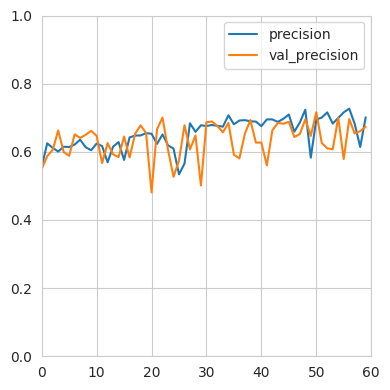

In [50]:
# 5. Plot model
history2_4_plot = pd.DataFrame(history2_4.history)
history2_4_plot.loc[: , ['loss', 'val_loss']].plot()
plt.xlim(0, 60)
plt.ylim(0,2)

plt.figure()
history2_4_plot.loc[: , ['precision', 'val_precision']].plot()
plt.xlim(0, 60)
plt.ylim(0,1)

It looks like the last dense layer is making the model too complex. Let's reduce the number of units and add dropout.

#### Experiment 4: *Reducing Dense units and adding dropout*

In [51]:
# 1. Load a convolutional base with pre-trained weights
inceptionv3_base_model_test5 = load_model('/kaggle/input/radimagenet/RadImageNet-InceptionV3_notop.h5')

# - Freeze the base model
for layer in inceptionv3_base_model_test4.layers[:-4]:
    layer.trainable = False

# 2. Build model
model2_5 = tf.keras.Sequential([
    inceptionv3_base_model_test5,
    layers.Dropout(0.2),
    layers.Flatten(),
    
    layers.Dense(10, activation='relu'),
    layers.Dense(4, activation='softmax')
    
])

# 3. Compile model
model2_5.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(epsilon=0.01, learning_rate=0.01),
                metrics = ['precision'])

# 4. Fit model
start = time.time()
# 4. Fit model
history2_5 = model2_5.fit(X_train_resized_ds, y_train_ds,
    steps_per_epoch=len(X_train_resized_ds),
    epochs=40,
    batch_size=32,
    validation_data=[X_val_resized_ds, y_val_ds],
    validation_steps=len(X_val_resized_ds))

print('It takes %s minutes' % ((time.time() - start)/60))

Epoch 1/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 125s 10ms/step - loss: 1.0047 - precision: 0.6696 - val_loss: 1.1115 - val_precision: 0.7236
Epoch 2/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - loss: 0.7918 - precision: 0.7314 - val_loss: 0.9162 - val_precision: 0.5654
Epoch 3/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.6570 - precision: 0.7865 - val_loss: 0.8880 - val_precision: 0.7478
Epoch 4/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.5990 - precision: 0.8140 - val_loss: 1.1277 - val_precision: 0.5882
Epoch 5/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.4284 - precision: 0.8727 - val_loss: 1.7559 - val_precision: 0.5474
Epoch 6/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.3004 - precision: 0.9137 - val_loss: 0.9507 - val_precision: 0.7086
Epoch 7/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.2612 - precision: 0.9259 - val_loss: 0.5236 - val_precision: 0.8566
Epoch 8/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.26

<Axes: >

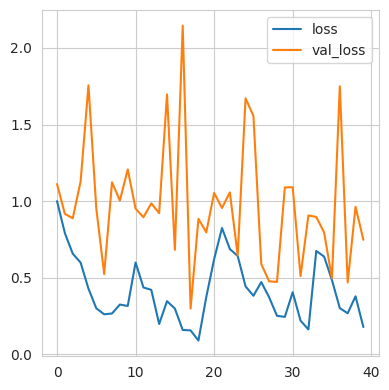

In [52]:
# 5. Plot model
history2_5_plot = pd.DataFrame(history2_5.history)
history2_5_plot.loc[: ,['loss', 'val_loss']].plot()

(0.0, 1.0)

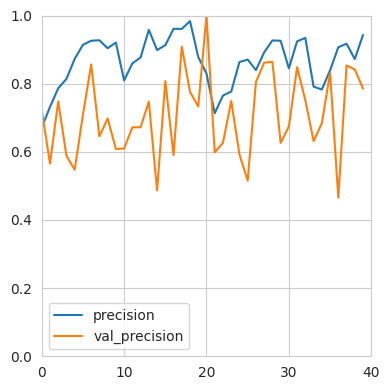

In [53]:
history2_5_plot.loc[:, ['precision', 'val_precision']].plot()
plt.xlim(0, 40)
plt.ylim(0, 1)

****

# Evaluate Best Models on Test Data

#### Define functions to process test results

In [54]:
# Create function to turn prediction array into classification instead of probabilities
def prediction_class(preds):

    for i in range(len(preds)):
        # Find max class probability and change to 1
        preds[i, tf.argmax(preds[i])] = 1
        # Round the rest of the values to 0
        preds[i] = tf.round(preds[i])
        
    return preds

In [55]:
# Create function to turn numeric output into string output
def numeric_to_class_names(preds, class_names=class_names):
    preds_names = []
    for i in range(len(preds)):
        preds_names.append(class_names[tf.argmax(preds[i])])   
    
    return preds_names                  

### Model 1: *Custom Convnet*

In [56]:
preds1_3 = model1_3.predict(X_test_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [57]:
preds_names1_3 = numeric_to_class_names(preds1_3)
preds_namestest = numeric_to_class_names(y_test_ds)

In [58]:
test_df = pd.DataFrame(data={'Model1_3_preds': preds_names1_3, 'Test_Labels': preds_namestest})
test_df.head()

,Model1_3_preds,Test_Labels
0,Moderate Demented,Moderate Demented
1,Non Demented,Non Demented
2,Mild Demented,Mild Demented
3,Moderate Demented,Moderate Demented
4,Non Demented,Non Demented


<Axes: >

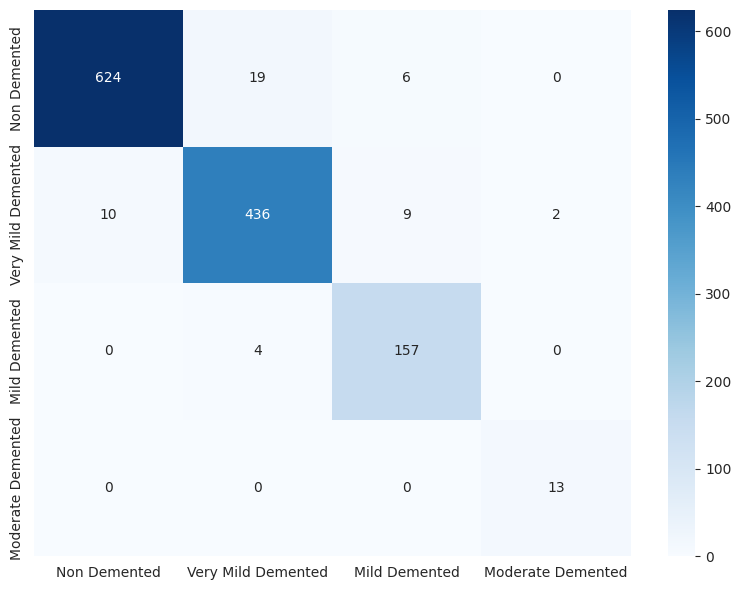

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm1_3 = confusion_matrix(test_df.Model1_3_preds, test_df.Test_Labels)
cm_df1_3 = pd.DataFrame(cm1_3,
                     index = ['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented'], 
                     columns = ['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df1_3, annot=True, fmt='g', cmap='Blues')

### Model 2: *InceptionV3 pretrained base*

In [60]:
preds2_5 = model2_5.predict(X_test_resized_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step


In [61]:
preds_names2_5 = numeric_to_class_names(preds2_5)
preds_namestest = numeric_to_class_names(y_test_ds)

In [62]:
test_df = pd.DataFrame(data={'Model2_5_preds': preds_names2_5, 'Test_Labels': preds_namestest})
test_df.head()

,Model2_5_preds,Test_Labels
0,Mild Demented,Moderate Demented
1,Mild Demented,Non Demented
2,Mild Demented,Mild Demented
3,Moderate Demented,Moderate Demented
4,Moderate Demented,Non Demented


<Axes: >

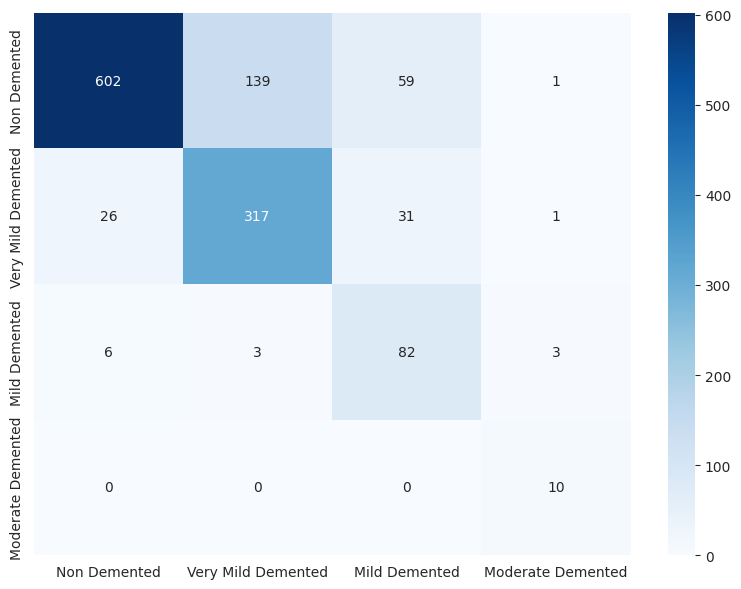

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm2_5 = confusion_matrix(test_df.Model2_5_preds, test_df.Test_Labels)
cm_df2_5 = pd.DataFrame(cm2_5,
                     index = ['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented'], 
                     columns = ['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df2_5, annot=True, fmt='g', cmap='Blues')

****

# **Analyses and Conclusion**

We found that the custom convolutional net outperformed the InceptionV3 pretrained base. The pretrained base was not fine-tuned to our specific use case enough and thus struggled to predict the smallest class. Had the classes been more balanced there might have been a closer competition between the models. However, the lack of 'Moderate Demented' images proved to be troublesome. Augmentation was considered, however due to the nature of Alzheimers, altering the images could change the class and was considered too risky to achieve. Regardless, the custom convolutional net achieved fairly satisfactory results in good time, but overfit a bit. Further optimisation would be required before deployment. Future steps would include gathering more data, gaining more domain knowledge to learn ways to make more use of our current data as well as hyperpareameter tuning. A user-friendly interface for deployment could be considered as an extension as well.

****

# **References**

`@dataset{alzheimer_mri_dataset,
  author = {Falah.G.Salieh},
  title = {Alzheimer MRI Dataset},
  year = {2023},
  publisher = {Hugging Face},
  version = {1.0},
  url = {https://huggingface.co/datasets/Falah/Alzheimer_MRI}
}`

https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a

https://insightsimaging.springeropen.com/articles/10.1007/s13244-018-0639-9

https://towardsdatascience.com/loss-functions-and-their-use-in-neural-networks-a470e703f1e9

https://insightsimaging.springeropen.com/articles/10.1007/s13244-018-0639-9

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8321322/

https://medium.com/@thecybermarty/multi-class-activation-functions-df969651d4c5#:~:text=Softmax%20is%20the%20most%20commonly,make%20decisions%20based%20on%20them.

https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/